# QuantitativeTrading

## Librerías

In [1]:
#Manipulación de datos
import pandas as pd 
#Configuramos pandas para mostrarnos 20 filas
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

#Gráficas
import matplotlib.pyplot as plt 

#cálculos numéricos
import numpy as np 

#manipulación de la variable tiempo
import datetime 

#Modelado
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression

#Otros
import random #Generar números aleatorios
import pickle #Almacenamiento local
import itertools #Generacion de combinaciones
#import math
#import scipy.special

## Funciones

In [2]:
## Lista de las posibles combinaciones de columnas de un dataframe
def list_cobmination_columns(df,num_max_comb):
    list_cobmination_columns=[]
    df_columns = df.columns
    for i in range (1,min(num_max_comb,len(df_columns))+1):
        for _, j in enumerate(itertools.combinations(df_columns, i)):
            list_cobmination_columns.append(list(j))
    return list_cobmination_columns

## Carga de datos

In [3]:
#Cargamos el fichero de cotizaciones seleccionando las columnas relevantes para el modelo
path='C:\\Users\\manuel.decesar\\Desktop\\data_labqt\\'
df=pd.read_csv(path+'WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv', sep=',')[['ticker','date','adj_close','adj_volume']]  
print(len(df))
#fijamos los tipos de datos
df['date']=pd.to_datetime(df['date'])
print(len(df))
#cargamos el sector asociado al ticker
metadata=pd.read_csv(path+'us_equities_meta_data.csv')
df = pd.merge(df, metadata[["ticker","sector"]], on="ticker")
print(len(df))
df

15389314
15389314
12274396


,ticker,date,adj_close,adj_volume,sector
0,A,1999-11-18,30.018590,44739900.0,Capital Goods
1,A,1999-11-19,27.548879,10897100.0,Capital Goods
2,A,1999-11-22,30.018590,4705200.0,Capital Goods
3,A,1999-11-23,27.460188,4274400.0,Capital Goods
4,A,1999-11-24,28.012803,3464400.0,Capital Goods
5,A,1999-11-26,28.101494,1237100.0,Capital Goods
6,A,1999-11-29,28.742800,2914700.0,Capital Goods
7,A,1999-11-30,28.783735,3083000.0,Capital Goods
8,A,1999-12-01,29.295415,2115400.0,Capital Goods
9,A,1999-12-02,30.107281,2195900.0,Capital Goods


## Análisis y limpieza de datos

In [4]:
#Filtrar tickers sin suficiente volumen
#df=df.reset_index()
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
df=df[df['ticker'].isin(df_ticker_volume[df_ticker_volume>8.211].index)]
#Filtrar tickers sin suficientes cotizaciones
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
df=df[df['ticker'].isin(df_ticker_cot[df_ticker_cot>3.104].index)]
#Filtrar registros sin volumen
df=df[df['adj_close']>0]
#Filtro de fecha
df=df[df.date>='2001-01-01']
#Establecemos índice (ticker y fecha)
df=df.set_index(['ticker','date'])
print(len(df))
#df

7710723


(7.967, 8.496]      204
(8.496, 8.737]      204
(8.737, 8.93]       204
(8.93, 9.091]       204
(9.091, 9.252]      204
(9.252, 9.405]      204
(9.405, 9.612]      204
(9.612, 9.87]       204
(9.87, 10.185]      204
(10.185, 11.728]    204
Name: adj_volume, dtype: int64
total de tickers 2197
mediana de volumen ajustado por ticker 5383.999999999998


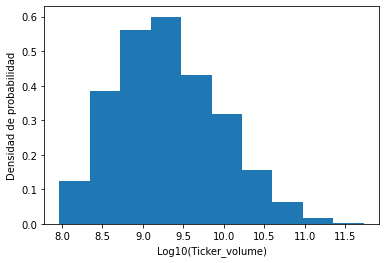

In [5]:
#Análisis volumen por ticker
%matplotlib inline
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
plt.hist(df_ticker_volume, density=True, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(Ticker_volume)');
#percentiles
print(pd.qcut(df_ticker_volume,10).value_counts().sort_index())
print('total de tickers',len(df_ticker_cot))
print('mediana de volumen ajustado por ticker',10**df_ticker_cot.median())


(3.1047, 3.6201]     680
(3.6201, 3.6369]    1353
(3.6369, 3.637]        7
Name: adj_close, dtype: int64
mediana de número de cotizaciones por ticker 4333.999999999999


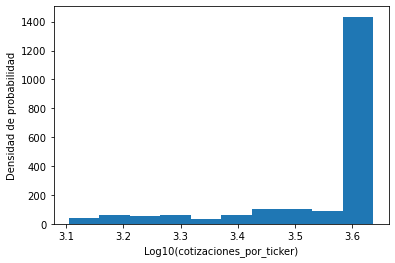

In [6]:
#Análisis cotizaciones por ticker
%matplotlib inline
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
plt.hist(df_ticker_cot, density=False, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(cotizaciones_por_ticker)');
#percentiles
print(pd.qcut(df_ticker_cot,3).value_counts().sort_index())
print('mediana de número de cotizaciones por ticker',10**df_ticker_cot.median())

In [7]:
#Análisis nulos
print(df.reset_index()[df.reset_index().ticker.isnull()])
print(df.reset_index()[df.reset_index().date.isnull()])
print(df.reset_index()[df.reset_index().adj_close.isnull()])
print(df.reset_index()[df.reset_index().adj_volume.isnull()])

Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []


(0.999, 1498.0]     871
(1498.0, 1746.6]    865
(1746.6, 1918.0]    869
(1918.0, 2026.0]    887
(2026.0, 2040.0]    848
Name: adj_close, dtype: int64
número de fechas 4340
mediana de número de tickers por fecha 1802.0


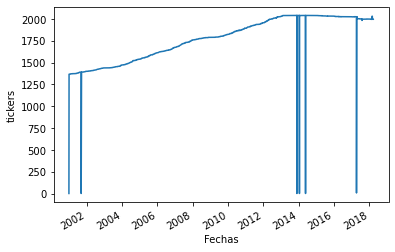

In [8]:
#Análisis discontinuidades de fechas
%matplotlib inline
df_date_tikers=df.groupby(['date'])['adj_close'].count()
df_date_tikers.plot()
plt.ylabel('tickers')
plt.xlabel('Fechas');
#percentiles
print(pd.qcut(df_date_tikers,5).value_counts().sort_index())
print('número de fechas',len(df_date_tikers))
print('mediana de número de tickers por fecha',df_date_tikers.median())

In [9]:
#tickers posibles
print(np.unique(df.index.get_level_values(0)))
#fechas posibles
print(np.unique(df.index.get_level_values(1)))

['A' 'AAL' 'AAN' ... 'ZNGA' 'ZTS' 'ZUMZ']
['2001-01-01T00:00:00.000000000' '2001-01-02T00:00:00.000000000'
 '2001-01-03T00:00:00.000000000' ... '2018-03-23T00:00:00.000000000'
 '2018-03-26T00:00:00.000000000' '2018-03-27T00:00:00.000000000']


## Filtrado para desarrollo e índice

In [10]:
#Filtrar muestra para desarrollo
#df=df.sort_values(by=['ticker'], ascending=False)[0:100000]#descomentar para desarrollar con una muestra de datos
df=df.sort_values(by=['ticker','date'])
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

7710723


## Creación de features

In [11]:
#dummies para el sector
print(df.sector.unique())
df = pd.get_dummies(data=df, columns=['sector'])
pickle.dump(df.columns, open(path+'columnas', 'wb'))
print(datetime.datetime.now(),': Extraido fichero de transformación en dummies: columnas')
columnas=pickle.load(open(path+'columnas', 'rb'))
print(columnas)
df=df.reindex(labels =columnas, axis = 1, fill_value = 0)

['Capital Goods' 'Transportation' 'Technology' 'Consumer Services'
 'Health Care' 'Finance' 'Consumer Durables' 'Miscellaneous'
 'Consumer Non-Durables' 'Public Utilities' 'Basic Industries' nan
 'Energy']
2022-01-20 17:17:46.162702 : Extraido fichero de transformación en dummies: columnas
Index(['adj_close', 'adj_volume', 'sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Durables',
       'sector_Consumer Non-Durables', 'sector_Consumer Services',
       'sector_Energy', 'sector_Finance', 'sector_Health Care',
       'sector_Miscellaneous', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation'],
      dtype='object')


In [12]:
#Calculamos el retorno respecto al día anterior: incremento relativo del ticker respecto el día anterior
df['return_d']=df.groupby(level='ticker')['adj_close'].pct_change()
#Calculamos el retorno respecto a la semana anterior: incremento relativo del ticker respecto a la semana anterior
df['return_w']=df.groupby(level='ticker')['adj_close'].pct_change(periods=5)
#Calculamos el retorno respecto al mes anterior: incremento relativo del ticker respecto el mes anterior
df['return_m']=df.groupby(level='ticker')['adj_close'].pct_change(periods=20)
#Calculamos el retorno respecto al año anterior: incremento relativo del ticker respecto el año anterior
df['return_y']=df.groupby(level='ticker')['adj_close'].pct_change(periods=252)
#df

In [13]:
#Volatilidad semanal del retorno diario
df['volatility_w_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_d'].rolling(5).std())
#Volatilidad mensual del retorno diario
df['volatility_m_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_m'].rolling(20).std())
#Volatilidad anual del retorno diario
df['volatility_y_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_y'].rolling(252).std())
#df

In [14]:
#Cierre ajustado promediado semanal
df['adj_close_m_pw']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(5).mean())
#Cierre ajustado promediado mensual
df['adj_close_m_pm']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(20).mean())
#Cierre ajustado promediado anual
df['adj_close_m_py']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(252).mean())

In [15]:
#Equivalente a macd para un día y una semana/mes/año
#Retorno respecto al cierre ajustado promediado semanal
df['return_m_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pw'])/x['adj_close_m_pw'], axis=1)
#Retorno respecto al cierre ajustado promediado mensual
df['return_m_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pm'])/x['adj_close_m_pm'], axis=1)
#Retorno respecto al cierre ajustado promediado anual
df['return_m_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_py'])/x['adj_close_m_py'], axis=1)

In [16]:
#Cierre ajustado promediado ponderado por volumen semanal
df['adj_close_vwm_pw']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(5).sum()/grp['adj_volume'].rolling(5).sum())
#Cierre ajustado promediado ponderado por volumen mensual
df['adj_close_vwm_pm']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(20).sum()/grp['adj_volume'].rolling(20).sum())
#Cierre ajustado promediado ponderado por volumen anual
df['adj_close_vwm_py']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(252).sum()/grp['adj_volume'].rolling(252).sum())
#df.loc['X']

In [17]:
#Filtramos los cierres promediados por volumen nulos
print(len(df))
df=df[df['adj_close_vwm_pw']!=0]
df=df[df['adj_close_vwm_pm']!=0]
df=df[df['adj_close_vwm_py']!=0]
print(len(df))

7710723
7710608


In [18]:
#Filtramos NaN y volvemos a establecer el índice
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

7710608
6681341


In [19]:
#Equivalente a macd para un día y una semana/mes/año ponderando por volumen
#Retorno respecto al cierre ajustado promediado ponderado semanal
df['return_vwm_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pw'])/x['adj_close_vwm_pw'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado mensual
df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado anual
df['return_vwm_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_py'])/x['adj_close_vwm_py'], axis=1)
#df

<ipython-input-19-7dae9c5cab6e>:3: RuntimeWarning: invalid value encountered in double_scalars
  df['return_vwm_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pw'])/x['adj_close_vwm_pw'], axis=1)
<ipython-input-19-7dae9c5cab6e>:5: RuntimeWarning: invalid value encountered in double_scalars
  df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)


## Creación del target y el peso

In [20]:
#Calculamos el retorno al día siguiente: incremento relativo del ticker en el día siguiente
df['return_f_d']=df.groupby(level='ticker')['adj_close'].pct_change().shift(periods=-1)
#percentiles
print(pd.qcut(df['return_f_d'][0:int(len(df)*.4)],10).value_counts().sort_index())
p10=pd.qcut(df['return_f_d'][0:int(len(df)*.4)],10).value_counts().sort_index().index.values[0].right
p90=pd.qcut(df['return_f_d'][0:int(len(df)*.4)],10).value_counts().sort_index().index.values[8].right
print(p10,p90)

(-0.861, -0.0256]       267186
(-0.0256, -0.0142]      267159
(-0.0142, -0.00792]     267174
(-0.00792, -0.00333]    267171
(-0.00333, 0.0]         267842
(0.0, 0.00412]          266503
(0.00412, 0.00869]      267172
(0.00869, 0.015]        267174
(0.015, 0.0265]         267171
(0.0265, 102.804]       267173
Name: return_f_d, dtype: int64
-0.0256 0.0265


In [21]:
#Calculamos target (retorno>0)
df['return_gt_0']=df.apply(lambda x: 1 if x['return_f_d']>0 else 0, axis=1)


In [22]:
#Calculamos el peso como el valor absoluto del retorno al día siguiente (retorno>0)
    #ponderando de forma variable los extremos
#df['sample_weight']=df.apply(lambda x:abs(x['return_f_d'])**(1/8), axis=1)
    #truncando los extremos
df['sample_weight']=df.apply(lambda x: abs(p10) if x['return_f_d']<p10 else abs(p90) if x['return_f_d']>p90 else abs(x['return_f_d']), axis=1)

In [23]:
#Filtramos NaN
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

6681341
6678423


## Partición del dataset

In [24]:
#Preparamos datasets de train, validation, test, final_test
df=df.sort_values('date')
lim_inicial=int(len(df)*.00)
lim_train=int(len(df)*.56)
lim_val=int(len(df)*.58)
lim_test=int(len(df)*.60)
df_train= df[lim_inicial:lim_train]
df_val=df[lim_train:lim_val]
df_train_val= df[lim_inicial:lim_val]
df_test= df[lim_val:lim_test]
df_final_test= df[lim_test:-1]
total_features=['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Non-Durables',
       'sector_Consumer Services', 'sector_Energy', 'sector_Finance',
       'sector_Health Care', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation']
target=['return_gt_0']
sample_weight=['sample_weight']

## Construcción del modelo

In [34]:
#Construimos un modelo de árbol de decisión con cv de features y profundidad
tiempo_busqueda=30*60 #en segundos
max_depth=4
max_features=100
#mask=['return_d', 'sector_Energy','return_y','return_m_py', 'return_vwm_py','return_m','volatility_y_rd', 'return_w']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services','return_m_py', 'return_vwm_py','return_m','volatility_y_rd']
mask=total_features
mask=['return_d','return_w','return_m','return_m_pw','return_m_pm','return_vwm_pw','return_vwm_pm']
#Estrategia random val
s=df_val.groupby('date')['return_f_d'].mean()
rcs_random_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random validacion',rcs_random_val)
#Estrategia random train
s=df_train.groupby('date')['return_f_d'].mean()
rcs_random_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random train',rcs_random_train)
#Selección de features y profundidad con cv
t=datetime.datetime.now()
depths=range(1,max_depth+1)
opt_depth=0
accuracy_cv=0.5
opt_features=[]
metric=-1000000
rcs_train='sin_calcular'
tt=datetime.datetime.now()
for i in depths:
    if (datetime.datetime.now()-tt).seconds>tiempo_busqueda:
        break
    print('depth',i)
    for features in list_cobmination_columns(df_train[mask],min(max_features, (2**i)-1)):
        if (datetime.datetime.now()-tt).seconds>tiempo_busqueda:
            break
        model = tree.DecisionTreeClassifier(max_depth=i)
        #metricas para el caso
        model = model.fit(df_train[features], df_train[target],sample_weight=df_train.sample_weight.values)
        #s=(df_train[[ True if x==1 else False for x in model.predict(df_train[features])]]).groupby('date')['return_f_d'].mean()
        #rcs_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
        s=(df_val[[ True if x==1 else False for x in model.predict(df_val[features])]]).groupby('date')['return_f_d'].mean()
        rcs_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
        print(features,rcs_val,rcs_train)
        if metric < rcs_val:# and (rcs_train/len(df_train)<3*rcs_val/len(df_val) or rcs_train<3*rcs_random_train):
            metric=rcs_val
            opt_depth=i
            opt_features=features
            accuracy_opt=sum(model.predict(df_train[features])==df_train.return_gt_0.values)/len(df_train[target])
            s=(df_train[[ True if x==1 else False for x in model.predict(df_train[features])]]).groupby('date')['return_f_d'].mean()
            rcs_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
            print('features_encontrados',opt_features,'Retorno validacion',rcs_val,'Retorno train',rcs_train,'Profundidad encontrada',opt_depth,'accuracy encontrada',accuracy_opt)
            rcs_train='sin_calcular'
t=datetime.datetime.now()-t
print('Selección de hiperparámetros terminada en ',t,' s')

#Validation
print('Validation')
#Accuraccy random validacion
y_random = []
for i in range(len(df_val)):
    n = random.randint(0,1)
    y_random.append(n)
print('accuracy random validation',sum(y_random==df_val.return_gt_0)/len(df_val.return_gt_0))
print(confusion_matrix(df_val.return_gt_0, y_random))

model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train[opt_features], df_train[target],sample_weight=df_train.sample_weight.values)

accuracy_train=sum(model.predict(df_train[opt_features])==df_train.return_gt_0.values)/len(df_train[target])
s=(df_train[[ True if x==1 else False for x in model.predict(df_train[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
accuracy_val=sum(model.predict(df_val[opt_features])==df_val.return_gt_0.values)/len(df_val[target])
s=(df_val[[ True if x==1 else False for x in model.predict(df_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Features optimos',opt_features,'Retorno en validation',rcs_val,'Retorno en train',rcs_train,'Profundidad optima',opt_depth,'accuracy_val',accuracy_val,'accuracy_train',accuracy_train)

y_pred_train=model.predict(df_train[opt_features])
y_train=df_train.return_gt_0.values
print('accuracy model train',sum(y_pred_train==y_train)/len(y_train))
print(confusion_matrix(y_train, y_pred_train))

y_pred_val=model.predict(df_val[opt_features])
y_val=df_val.return_gt_0.values
print('accuracy model val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))
#validacion(model,df_train[opt_features], df_train[target].values,df_val[opt_features], df_val[target].values)      

#Test
print('Test')
#Accuraccy random test
y_random = []
for i in range(len(df_test)):
    n = random.randint(0,1)
    y_random.append(n)
print('accuracy random test',sum(y_random==df_test.return_gt_0)/len(df_test.return_gt_0))
print(confusion_matrix(df_test.return_gt_0, y_random))

#Estrategia random test
s=df_test.groupby('date')['return_f_d'].mean()
rcs_random=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random test',rcs_random)

#Modelo final
model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train_val[opt_features], df_train_val[target],sample_weight=df_train_val.sample_weight.values)

#Metricas del modelo final
accuracy_test=sum(model.predict(df_test[opt_features])==df_test.return_gt_0.values)/len(df_test[target])
accuracy_train_val=sum(model.predict(df_train_val[opt_features])==df_train_val.return_gt_0.values)/len(df_train_val[target])
s=(df_test[[ True if x==1 else False for x in model.predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_test=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
s=(df_train_val[[ True if x==1 else False for x in model.predict(df_train_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Features optimos',opt_features,'Retorno en test',rcs_test,'Retorno en train_val',rcs_train_val,'Profundidad optima',opt_depth,'accuracy_test',accuracy_test,'accuracy_train_val',accuracy_train_val)

y_pred_val=model.predict(df_train_val[opt_features])
y_val=df_train_val.return_gt_0.values
print('accuracy model train_val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))

y_pred_test=model.predict(df_test[opt_features])
y_test=df_test.return_gt_0.values
print('accuracy model test',sum(y_pred_test==y_test)/len(y_test))
print(confusion_matrix(y_test, y_pred_test))
#validacion(model,df_val[opt_features], df_val[target].values,df_test[opt_features], df_test[target].values)



Retorno random validacion 0.014767514938080692
Retorno random train 2.1124478458258094
depth 1
['return_d'] 0.030897542787345394 sin_calcular
features_encontrados ['return_d'] Retorno validacion 0.030897542787345394 Retorno train 3.0233992010675217 Profundidad encontrada 1 accuracy encontrada 0.508217831630443
['return_w'] 0.03774145919110985 sin_calcular
features_encontrados ['return_w'] Retorno validacion 0.03774145919110985 Retorno train 3.0442405034798257 Profundidad encontrada 1 accuracy encontrada 0.5072228894980529
['return_m'] 0.01589737320627633 sin_calcular
['return_m_pw'] 0.06017072022836049 sin_calcular
features_encontrados ['return_m_pw'] Retorno validacion 0.06017072022836049 Retorno train 4.672926587011144 Profundidad encontrada 1 accuracy encontrada 0.512410973936313
['return_m_pm'] 0.0268969643344077 sin_calcular
['return_vwm_pw'] 0.06017364493805652 sin_calcular
features_encontrados ['return_vwm_pw'] Retorno validacion 0.06017364493805652 Retorno train 4.7611269879533

['return_d', 'return_vwm_pw', 'return_vwm_pm'] 0.025297151515542578 sin_calcular
['return_w', 'return_m', 'return_m_pw'] 0.024214281682659967 sin_calcular
['return_w', 'return_m', 'return_m_pm'] 0.03774145919110985 sin_calcular
['return_w', 'return_m', 'return_vwm_pw'] 0.02520825302163425 sin_calcular
['return_w', 'return_m', 'return_vwm_pm'] 0.03774145919110985 sin_calcular
['return_w', 'return_m_pw', 'return_m_pm'] 0.06017072022836049 sin_calcular
['return_w', 'return_m_pw', 'return_vwm_pw'] 0.0275661464565444 sin_calcular
['return_w', 'return_m_pw', 'return_vwm_pm'] 0.021117084380385693 sin_calcular
['return_w', 'return_m_pm', 'return_vwm_pw'] 0.030931890243641295 sin_calcular
['return_w', 'return_m_pm', 'return_vwm_pm'] 0.03774145919110985 sin_calcular
['return_w', 'return_vwm_pw', 'return_vwm_pm'] 0.022184687933932128 sin_calcular
['return_m', 'return_m_pw', 'return_m_pm'] 0.06017072022836049 sin_calcular
['return_m', 'return_m_pw', 'return_vwm_pw'] 0.0228891243461092 sin_calcular

KeyboardInterrupt: 

In [42]:
#Construimos un modelo de árbol de decisión con cv de profundidad
tiempo_busqueda=30*60 #en segundos
max_depth=10
max_features=100
#mask=['return_d', 'sector_Energy','return_y','return_m_py', 'return_vwm_py','return_m','volatility_y_rd', 'return_w']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services']
#mask=['return_d', 'return_w', 'return_y', 'volatility_w_rd', 'volatility_m_rd','sector_Consumer Services','return_m_py', 'return_vwm_py','return_m','volatility_y_rd']
mask=total_features
#mask=['return_d','return_w','return_m','return_m_pw','return_m_pm','return_vwm_pw','return_vwm_pm']
#Estrategia random val
s=df_val.groupby('date')['return_f_d'].mean()
rcs_random_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random validacion',rcs_random_val)
#Estrategia random train
s=df_train.groupby('date')['return_f_d'].mean()
rcs_random_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random train',rcs_random_train)
#Selección de features y profundidad con cv
t=datetime.datetime.now()
depths=range(1,max_depth+1)
opt_depth=0
accuracy_cv=0.5
opt_features=[]
metric=-1000000
rcs_train='sin_calcular'
tt=datetime.datetime.now()
for i in depths:
    if (datetime.datetime.now()-tt).seconds>tiempo_busqueda:
        break
    print('depth',i)
    model = tree.DecisionTreeClassifier(max_depth=i)
    #metricas para el caso
    model = model.fit(df_train[mask], df_train[target],sample_weight=df_train.sample_weight.values)
    s=(df_train[[ True if x==1 else False for x in model.predict(df_train[mask])]]).groupby('date')['return_f_d'].mean()
    rcs_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
    s=(df_val[[ True if x==1 else False for x in model.predict(df_val[mask])]]).groupby('date')['return_f_d'].mean()
    rcs_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
    print(rcs_val,rcs_train)
    if metric < rcs_val:# and (rcs_train/len(df_train)<3*rcs_val/len(df_val) or rcs_train<3*rcs_random_train):
        metric=rcs_val
        opt_depth=i
        opt_features=mask
        accuracy_opt=sum(model.predict(df_train[mask])==df_train.return_gt_0.values)/len(df_train[target])
        print('-->Profundidad encontrada',opt_depth,'Retorno validacion',rcs_val,'Retorno train',rcs_train,'accuracy encontrada',accuracy_opt)
t=datetime.datetime.now()-t
print('Selección de hiperparámetros terminada en ',t,' s')

#Validation
print('Validation')
#Accuraccy random validacion
y_random = []
for i in range(len(df_val)):
    n = random.randint(0,1)
    y_random.append(n)
print('accuracy random validation',sum(y_random==df_val.return_gt_0)/len(df_val.return_gt_0))
print(confusion_matrix(df_val.return_gt_0, y_random))

model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train[opt_features], df_train[target],sample_weight=df_train.sample_weight.values)

accuracy_train=sum(model.predict(df_train[opt_features])==df_train.return_gt_0.values)/len(df_train[target])
s=(df_train[[ True if x==1 else False for x in model.predict(df_train[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
accuracy_val=sum(model.predict(df_val[opt_features])==df_val.return_gt_0.values)/len(df_val[target])
s=(df_val[[ True if x==1 else False for x in model.predict(df_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('-->>Profundidad optima',opt_depth,'Retorno en validation',rcs_val,'Retorno en train',rcs_train,'accuracy_val',accuracy_val,'accuracy_train',accuracy_train)

y_pred_train=model.predict(df_train[opt_features])
y_train=df_train.return_gt_0.values
print('accuracy model train',sum(y_pred_train==y_train)/len(y_train))
print(confusion_matrix(y_train, y_pred_train))

y_pred_val=model.predict(df_val[opt_features])
y_val=df_val.return_gt_0.values
print('accuracy model val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))
#validacion(model,df_train[opt_features], df_train[target].values,df_val[opt_features], df_val[target].values)      

#Test
print('Test')
#Accuraccy random test
y_random = []
for i in range(len(df_test)):
    n = random.randint(0,1)
    y_random.append(n)
print('accuracy random test',sum(y_random==df_test.return_gt_0)/len(df_test.return_gt_0))
print(confusion_matrix(df_test.return_gt_0, y_random))

#Estrategia random test
s=df_test.groupby('date')['return_f_d'].mean()
rcs_random=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('Retorno random test',rcs_random)

#Modelo final
model = tree.DecisionTreeClassifier(max_depth=opt_depth)
model = model.fit(df_train_val[opt_features], df_train_val[target],sample_weight=df_train_val.sample_weight.values)

#Metricas del modelo final
accuracy_test=sum(model.predict(df_test[opt_features])==df_test.return_gt_0.values)/len(df_test[target])
accuracy_train_val=sum(model.predict(df_train_val[opt_features])==df_train_val.return_gt_0.values)/len(df_train_val[target])
s=(df_test[[ True if x==1 else False for x in model.predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_test=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
s=(df_train_val[[ True if x==1 else False for x in model.predict(df_train_val[opt_features])]]).groupby('date')['return_f_d'].mean()
rcs_train_val=((s.cumsum())[-2:-1]).values[0] if len(s)>1 else 0
print('-->>>Profundidad optima',opt_depth,'Retorno en test',rcs_test,'Retorno en train_val',rcs_train_val,'Profundidad optima',opt_depth,'accuracy_test',accuracy_test,'accuracy_train_val',accuracy_train_val)

y_pred_val=model.predict(df_train_val[opt_features])
y_val=df_train_val.return_gt_0.values
print('accuracy model train_val',sum(y_pred_val==y_val)/len(y_val))
print(confusion_matrix(y_val, y_pred_val))

y_pred_test=model.predict(df_test[opt_features])
y_test=df_test.return_gt_0.values
print('accuracy model test',sum(y_pred_test==y_test)/len(y_test))
print(confusion_matrix(y_test, y_pred_test))
#validacion(model,df_val[opt_features], df_val[target].values,df_test[opt_features], df_test[target].values)



Retorno random validacion 0.014767514938080692
Retorno random train 2.1124478458258094
depth 1
0.06017072022836049 4.672926587011144
-->Profundidad encontrada 1 Retorno validacion 0.06017072022836049 Retorno train 4.672926587011144 accuracy encontrada 0.512410973936313
depth 2
0.06017072022836049 4.672926587011144
depth 3
0.015960210034754667 2.7090179981249745
depth 4
0.019052065053989896 2.8945588377975593
depth 5
0.03563014844730471 4.025452197433485
depth 6
0.03309945670265882 3.7239361688297667
depth 7
0.034909433919232305 4.019653166821502
depth 8
0.033056897816630904 4.112166141474264
depth 9
0.027429580659648636 3.762027619581547
depth 10
0.0335176339768994 4.038189832691946
Selección de hiperparámetros terminada en  0:11:37.217469  s
Validation
accuracy random validation 0.49791493535176573
[[33655 33872]
 [33191 32851]]
-->>Profundidad optima 1 Retorno en validation 0.06017072022836049 Retorno en train 4.672926587011144 accuracy_val 0.5076177855640156 accuracy_train 0.5124109

## Análisis de estrategias

Retornos diarios


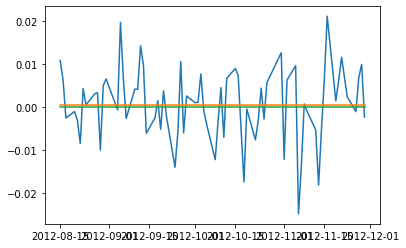

Retornos diarios acumulados sin reinvertir


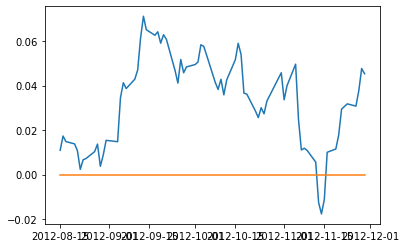

Retornos diarios acumulados reinvirtiendo


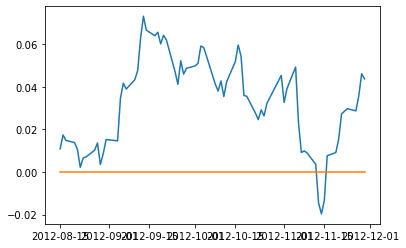

Retorno final acumulado 0.046156902500617436


In [43]:
#Retornos diarios estrategia dummy (estrategia de repartir a partes iguales entre todos los tickers diariamente)
s=df_test.groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

<ipython-input-44-9f2d82d1d8ca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s=df_test[df['return_d']>0].groupby('date')['return_f_d'].mean()


Retornos diarios


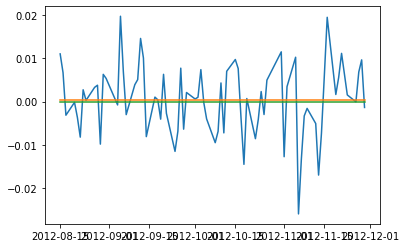

Retornos diarios acumulados sin reinvertir


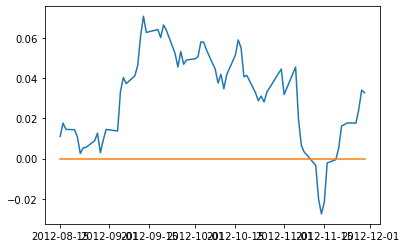

Retornos diarios acumulados reinvirtiendo


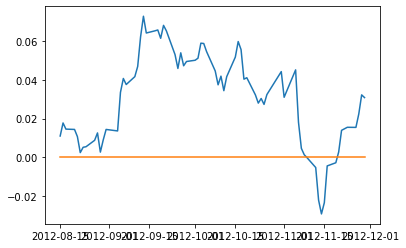

Retorno final acumulado 0.032236484164497314


In [44]:
#Retornos diarios estrategia básica (estrategia de repartir diariamente a partes iguales entre todos los tickers con retorno positivo respecto al día anterior)
s=df_test[df['return_d']>0].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

Retornos diarios


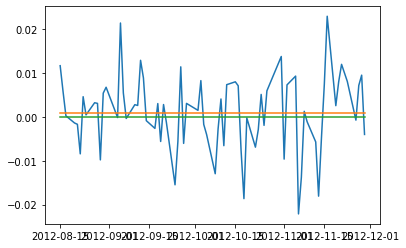

Retornos diarios acumulados sin reinvertir


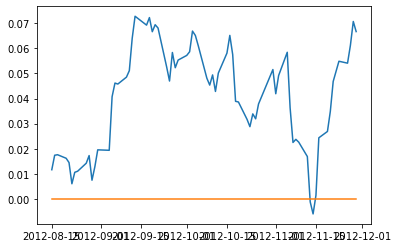

Retornos diarios acumulados reinvirtiendo


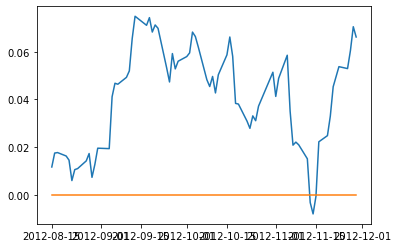

Retorno final acumulado 0.07046279113795806


In [45]:
#Retornos diarios modelo básico (estrategia de repartir diariamente a partes iguales entre todos los tickers predichos con retorno positivo al día siguiente)
s=((df_test)[[ True if x==1 else False for x in model.predict(df_test[opt_features])]]).groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

<ipython-input-46-169ffd9cc59f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s=(df_test)[df['return_f_d']>0].groupby('date')['return_f_d'].mean()


Retornos diarios


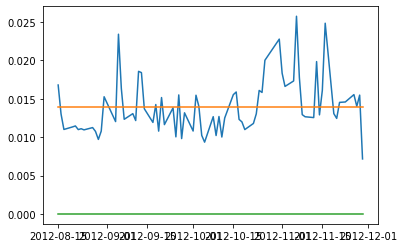

Retornos diarios acumulados sin reinvertir


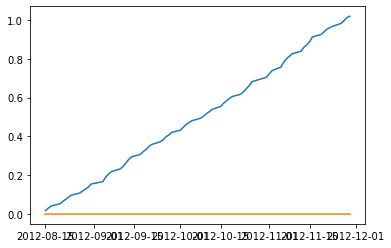

Retornos diarios acumulados reinvirtiendo


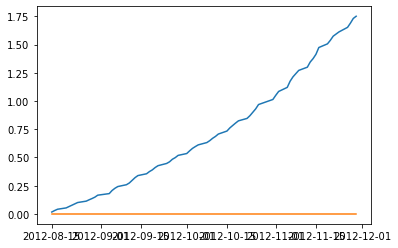

Retorno final acumulado 1.7320662166004022


In [46]:
#Retornos diarios estrategia dios  (estrategia de repartir diariamente a partes iguales entre todos los tickers que tendrán retorno positivo (supone conocer el futuro))
s=(df_test)[df['return_f_d']>0].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()
print('Retorno final acumulado',(rcs[-2:-1]-1).values[0])

## Siguientes pasos

- Modelo para un día
- Introducir ventana de entrenamiento como hiperparámetro
- Backtesting
- Introducir otro modelo
- Añadir hiperparámetros
- Añadir features
- Personalizar scoring sklearn
- Pasar listas a series o dataframes
- Usar pandas clip para los pesos